# Setup

In [19]:
import pandas as pd
import numpy as np
import warnings

from io import StringIO
from calitp.tables import tbl
from datetime import date, datetime
from siuba import *
from plotnine import *

def friendly_date(x): 
    return datetime.strptime(x, "%Y-%m-%d").strftime("%b %d")

In [20]:
DIR_PATH="2021/05/106"

#CALITP_ITP_ID = 10
#CALITP_ITP_ID=45
#CALITP_ITP_ID=269
#CALITP_ITP_ID=108
#CALITP_ITP_ID=106
CALITP_ITP_ID=296
CALITP_URL_NUMBER = 0
DEBUG = False

DATE_START = "2021-11-01"
DATE_END = "2021-11-30"
PUBLISH_DATE = "2021-12-01"

CHANGE_PLOT_BREAKS = ["Added", "Removed", "Unchanged"]
CHANGE_PLOT_VALUES = ["#51BF9D","#E16B26", "#8CBCCB"]

In [21]:
DATE_TODAY=date.today()
START_MONTH_DAY = friendly_date(DATE_START)
END_MONTH_DAY = friendly_date(DATE_END)

WEEK_MARKERS = pd.date_range(DATE_START, DATE_END, freq="W").astype(str).tolist()
BIWEEKLY_MARKERS = pd.date_range(DATE_START, DATE_END, freq="2W").astype(str).tolist()

In [22]:
if not DEBUG:
    warnings.filterwarnings("ignore")

In [23]:
# Convenience functions ----

filter_start = filter(
    _.calitp_extracted_at <= DATE_START,
    _.calitp_deleted_at.fillna("2099-01-01") > DATE_START,
)

filter_end = filter(
    _.calitp_extracted_at <= DATE_END,
    _.calitp_deleted_at.fillna("2099-01-01") > DATE_END,
)

filter_itp = filter(
    _.calitp_itp_id == CALITP_ITP_ID, _.calitp_url_number == CALITP_URL_NUMBER
)

def collect_to_dict(df):
    """Return the first row of a DataFrame as a dictionary.
    
    If there are no rows, then all dictionary values are None.
    """
    
    result = collect(df)
    
    if len(result) == 0:
        return {k: None for k in result.columns}
    elif len(result) > 1:
        raise ValueError("table contained more than 1 row")
    else:
        return result.iloc[0,:].to_dict()


select_rm_calitp = select(
    -_.calitp_itp_id,
    -_.calitp_url_number,
    -_.calitp_hash,
    -_.calitp_extracted_at,
    -_.calitp_deleted_at,
)

def percent_format(labels):
    return ["{:.0f}%".format(v*100) for v in labels]

def query_id_changes(start_table, end_table, id_vars):
    """Calculate id variables that are removed, added, or unchanged between tables.
    
    It works by adding a special column to each table, performing a full join,
    then checking where the special column is null.
    """
    sym_id_vars = [_[k] for k in id_vars]

    is_in_start = start_table >> select(*id_vars) >> mutate(is_in_start=True)
    is_in_end = end_table >> select(*id_vars) >> mutate(is_in_end=True)

    baseline = start_table >> count(*id_vars) >> rename(n_baseline="n")
    tallies = (
        is_in_start
        >> full_join(_, is_in_end, id_vars)
        >> count(*sym_id_vars, _.is_in_start, _.is_in_end)
        >> mutate(
            status=case_when(
                _,
                {
                    _.is_in_end.isna(): "Removed",
                    _.is_in_start.isna(): "Added",
                    True: "Unchanged",
                },
            )
        )
        >> count(*sym_id_vars[:-1], _.status)
        >> group_by(*sym_id_vars[:-1])
        >> mutate(percent=_.n / _.n.sum())
    )

    return tallies

In [6]:
# Data ====
# 1. High level feed info ----
feed_info = (
    tbl.gtfs_schedule_type2.feed_info()
    >> filter_end
    >> filter_itp
    >> select_rm_calitp
    >> pipe(collect_to_dict)
)

_n_routes = (
    tbl.gtfs_schedule_type2.routes() >> filter_end >> filter_itp >> count() >> collect()
)
_n_stops = (
    tbl.gtfs_schedule_type2.stops() >> filter_end >> filter_itp >> count() >> collect()
)

feed_info["n_routes"] = int(_n_routes.loc[0, "n"])
feed_info["n_stops"] = int(_n_stops.loc[0, "n"])

status = (
    # note that dim feeds also now contains all feed_info information, but we've left in the
    # gtfs_schedule_type2.feed_info table above. Could refactor and remove it in the future, and put
    # all info in one table.
    tbl.views.gtfs_schedule_dim_feeds()
    >> filter(_.calitp_itp_id == CALITP_ITP_ID, _.calitp_url_number == CALITP_URL_NUMBER)
    >> filter_end    
    >> select(_.calitp_agency_name, _.gtfs_schedule_url == _.calitp_gtfs_schedule_url)
    >> pipe(collect_to_dict)
)

# 2. Monthly metrics ----
# Service hours per day. Note that the queried table calculates service
# hours per service id, so we need to sum across service ids for the day
_cross_cal = (
    tbl.views.dim_date()
    >> filter(_.full_date.between(DATE_START, DATE_END))
    >> select(_.service_date == _.full_date)
)

tbl_daily_service_hours = (
    tbl.views.gtfs_schedule_fact_daily_service()
    >> filter_itp
    >> filter(_.service_date.between(DATE_START, DATE_END))
    >> right_join(_, _cross_cal, ["service_date"])
    >> collect()
    >> group_by(_.service_date)
    >> summarize(
        ttl_service_hours=(_.last_arrival_ts.max() - _.first_departure_ts.min()) / 3600,
        ttl_service_hours2=_.ttl_service_hours.sum(),
    )
    >> mutate(
        ttl_service_hours=_.ttl_service_hours.astype(float).round(2),
        service_date=_.service_date.astype("datetime64[ns]"),
    )
)

# number of days where a feed did not have any trips in service
n_expired_days = (
    tbl_daily_service_hours
    >> filter(_.ttl_service_hours.isna())
    >> pipe(lambda d: {"n": d.shape[0]})
)

# 3. Stop and Route ID Changes ----

query_id_changes = (
    # note that we remove these ids from the base fact table, since they are accessible via the
    # join below, and will likely be removed from the table in the future.
    select(-_.calitp_itp_id, -_.calitp_url_number)
    >> filter(_.metric_period == "month")
    >> inner_join(
        _,
        tbl.views.gtfs_schedule_dim_feeds() >> select(_.feed_key, _.calitp_itp_id, _.calitp_url_number),
        "feed_key"
    )
    >> filter_itp 
    # note that metric dates for calendar type roll-ups (e.g. month, quarter) is the first day of the next
    # period (e.g. metric date June 1st rolls up May).
    >> filter(_.metric_date == PUBLISH_DATE)
    >> rename(status = "change_status")
    >> mutate(percent = _.n / _.n.sum())
    >> collect()
)

tbl_stops_changed = tbl.views.gtfs_schedule_fact_stop_id_changes() >> query_id_changes
tbl_routes_changed = tbl.views.gtfs_schedule_fact_route_id_changes() >> query_id_changes

In [7]:
# 4. Feed files being checked for ----

file_categories = pd.DataFrame(
    {
        "shapes.txt": "Visual display",
        "pathways.txt": "Navigation",
        "levels.txt": "Navigation",
        "fare_rules.txt": "Fares",
        "fare_leg_rules.txt": "Fares",
        "feed_info.txt": "Technical contacts",
    }.items(),
    columns=["name", "category"],
)

importance = ["Visual display", "Navigation", "Fares", "Technical contacts"]

tbl_file_check = (
    tbl.gtfs_schedule_history.calitp_files_updates()
    >> filter_itp
    >> filter(_.calitp_extracted_at.isin(BIWEEKLY_MARKERS))
    >> select(_.name, _.calitp_extracted_at)
    >> collect()
    >> right_join(_, file_categories, ["name"])
    >> mutate(
        calitp_extracted_at=_.calitp_extracted_at.fillna("missing").astype(str),
        success="✅",
    )
    >> spread(_.calitp_extracted_at, _.success)
    >> select(-_.missing)
    >> arrange(_.category.apply(importance.index))
    >> select(_.category, _.contains(""))
    >> pipe(_.fillna(""))
)

# Analyze validation notices ----

from sqlalchemy.sql import func
# mark = lambda df: "X"

# code_reports = dict(
    
#     invalid_phone_number = "{filename}: {fieldValue}",
#     leading_or_trailing_whitespaces = "{filename}: {fieldValue}",
#     stop_time_with_only_arrival_or_departure_time = lambda df: f"Affected rows: {df.shape[0]}",
#     attribution_without_role = mark,
#     feed_info_lang_and_agency_mismatch_notice = mark,
#     inconsistent_agency_lang = mark,
#     missing_feed_info_date = mark,
#     route_color_contrast = mark,
#     unused_shape_notice = mark,
#     unused_trip_notice = mark,
#     unknown_column_notice = mark,
#     io_error = mark,
#     runtime_exception_in_loader_error = mark, 
#     runtime_exception_in_validator_error = mark, 
#     thread_execution_error = mark,
#     uri_syntax_error = mark
# )

tbl_biweekly = (
    tbl.views.dim_date()
    >> filter(_.full_date.isin(BIWEEKLY_MARKERS))
    >> select(_.date == _.full_date)
)

tbl_validation_notices_raw = (
    tbl.gtfs_schedule_type2.validation_notices()
    >> filter_itp
    >> inner_join(
        _,
        tbl_biweekly,
        sql_on = (lambda lhs, rhs:
                  (lhs.calitp_extracted_at <= rhs.date) &
                  (func.coalesce(lhs.calitp_deleted_at, "2099-01-01") > rhs.date)
        )
    )
    # do a simple count of the number of notices on each date
    >> count(_.date, _.code)
    >> collect()
)

In [8]:
# create a DataFrame with correct columns and no rows
_validation_empty = pd.DataFrame(
    dict([("code", []), *zip(BIWEEKLY_MARKERS, [tuple()] * len(BIWEEKLY_MARKERS))])
)

# spread validation notices so dates are columns, and counts are values
# TODO: when we spread the dates out, the counts sometimes can become floats,
# so have decimals, which might look funky. We can fix this by either converting
# the counts to strings before the code below
if not tbl_validation_notices_raw.shape[0]:
    _tbl_validation_notices = _validation_empty
else:
    out_wide = (
        tbl_validation_notices_raw >> mutate(date=_.date.astype(str)) >> spread(_.date, _.n)
    )
    
    _tbl_validation_notices = pd.concat(
        [_validation_empty, out_wide], ignore_index=True
    ).fillna("")

In [9]:
tbl_code_descriptions = (
    tbl.views.validation_code_descriptions()
    >> select(_.code, _.human_readable_description)
    >> collect()
    # convert code to snakecase,
    # note that this currently screws up cases like IO -> i_o
    >> mutate(code = _.code.str.replace(r'(?<!^)(?=[A-Z])', '_').str.lower().str.replace("_notice$", ""))
)

tbl_validation_notices = (
    _tbl_validation_notices 
    >> inner_join(_, tbl_code_descriptions, ["code"])
    >> select(_.code, _.human_readable_description, _.contains(""))
)

## Dump data

In [10]:
# Note that everything is saved in this cell, except for plots,
# which are saved in the cell they're defined in

import json
import shutil

from pathlib import Path

def to_rowspan_table(df, span_col):
    d = df.to_dict(orient="split")
    row_span = df.groupby(span_col)[span_col].transform("count")
    not_first = df[span_col].duplicated()
    
    row_span[not_first] = 0
    
    d["rowspan"] = row_span.tolist()
    return d


out_dir = Path(f"outputs/{DIR_PATH}/data")
out_dir.mkdir(parents=True, exist_ok=True)


json.dump(feed_info, open(out_dir / "1_feed_info.json", "w"))
json.dump(status, open(out_dir / "1_status.json", "w"))

tbl_daily_service_hours.to_json(
    out_dir / "2_daily_service_hours.json", orient="records"
)
json.dump(n_expired_days, open(out_dir / "2_n_expired_days.json", "w"))

tbl_stops_changed.to_json(out_dir / "3_stops_changed.json", orient="records")
tbl_routes_changed.to_json(out_dir / "3_routes_changed.json", orient="records")

json.dump(to_rowspan_table(tbl_file_check, "category"), open(out_dir / "4_file_check.json", "w"))
tbl_validation_notices.to_json(out_dir / "4_validation_notices.json", orient="split")

# Monthly GTFS Quality Report

In [11]:
from IPython.display import Markdown

Markdown(f"""
Transit provider name: {feed_info["feed_publisher_name"]}

Date generated: {DATE_TODAY}
""")


Transit provider name: Santa Cruz Metro

Date generated: 2021-12-06


This is a monthly report, generated by the California Integrated Travel Project ([Cal-ITP](https://dot.ca.gov/cal-itp/cal-itp-gtfs)), summarizing issues discovered by [MobilityData](http://mobilitydata.io/)’s [GTFS Validator](https://github.com/MobilityData/gtfs-validator). This report is available for viewing by the general public to support continuous improvement of GTFS data and the experience of transit passengers. 

## Overview

In [12]:
Markdown(f"""
Feed location: {status["gtfs_schedule_url"]}

Metrics for the most recent published version of the feed:

* Date published: {feed_info["feed_version"]}
* Number of routes in any service: {feed_info["n_routes"]}
* Number of stops in service: {feed_info["n_stops"]}
""")


Feed location: http://scmtd.com/google_transit/google_transit.zip

Metrics for the most recent published version of the feed:

* Date published: None
* Number of routes in any service: 25
* Number of stops in service: 794


## Aggregated Metrics for May

In [13]:
# TODO: 

# Markdown(f"""
# Days when the active feed was expired: {n_expired_days["n"]}
# """)

Markdown(f"""
Days with no service hours: {n_expired_days["n"]}
""")



Days with no service hours: 0


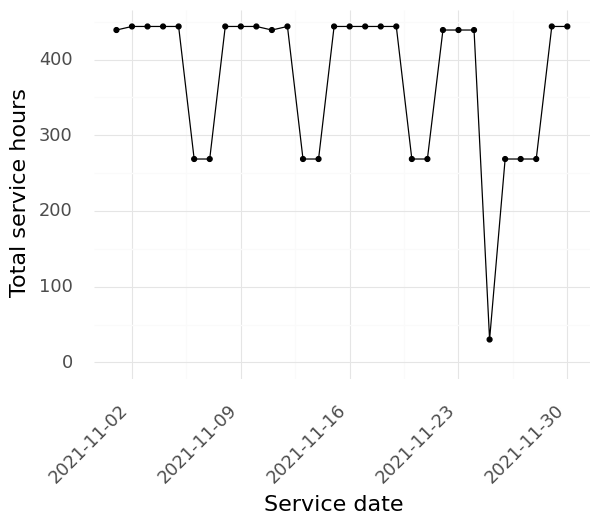

In [14]:
p = (
    tbl_daily_service_hours
    >> ggplot(aes("service_date", "ttl_service_hours2"))
    + geom_line()
    + geom_point()
    + theme_minimal(base_size=16)    
    + theme(axis_text_x=element_text(angle=45, hjust=1))
    + scale_x_datetime(date_breaks="1 week")
    + expand_limits(y=0)
    + labs(
        y = "Total service hours",
        x = "Service date",
        #title="Service hours per day"
    )
)

p.save(out_dir / "2_service_hours.png", width=4, height=4, dpi=300)
#p.save(out_dir / "2_service_hours.png")

p.draw();

## Changes Since Previous Month

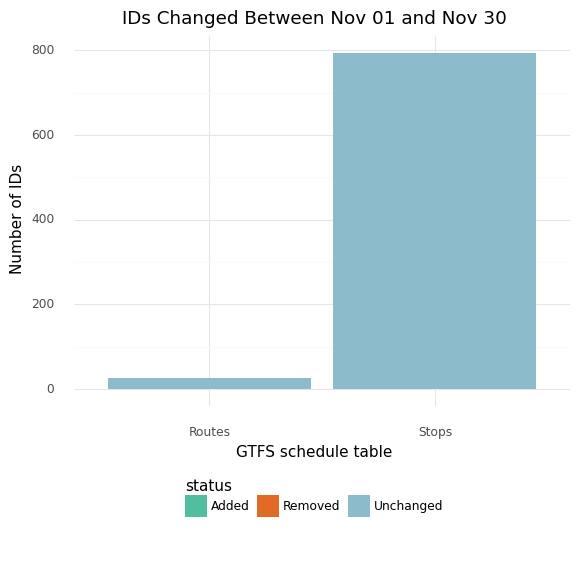

In [15]:
from siuba.dply.forcats import fct_rev

p = (
    pd.concat(
        [
            tbl_stops_changed >> mutate(kind="Stops"),
            tbl_routes_changed >> mutate(kind="Routes"),
        ]
    )
    >> mutate(status = fct_rev(_.status))
    >> ggplot(aes("kind", "n", fill="status"))
    + geom_col()
    + scale_fill_manual(limits = CHANGE_PLOT_BREAKS, values = CHANGE_PLOT_VALUES)
    + labs(
        x="GTFS schedule table",
        y="Number of IDs",
        title=f"IDs Changed Between {START_MONTH_DAY} and {END_MONTH_DAY}",
    )
    + theme_minimal()
        + theme(legend_position="bottom", legend_margin=30)
)


#p.save(out_dir / "3_id_changes.png")

p.draw();

### (Alternative version using percentages)

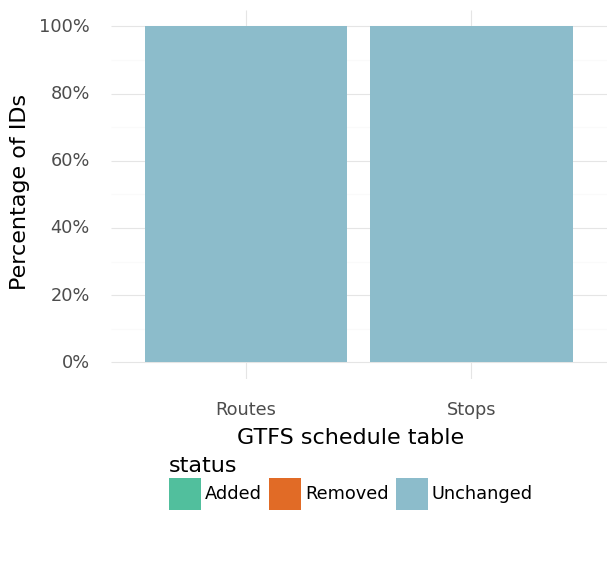

In [16]:
p = (
    pd.concat(
        [
            tbl_stops_changed >> mutate(kind="Stops"),
            tbl_routes_changed >> mutate(kind="Routes"),
        ]
    )
    >> mutate(status = fct_rev(_.status))    
    >> ggplot(aes("kind", "percent", fill="status"))
    + geom_col()
    + scale_fill_manual(limits = CHANGE_PLOT_BREAKS, values = CHANGE_PLOT_VALUES)
    + labs(
        x="GTFS schedule table",
        y="Percentage of IDs",
        #title=f"IDs Changed Between {START_MONTH_DAY} and {END_MONTH_DAY}",
    )
    + scale_y_continuous(labels=percent_format, breaks=np.arange(0, 1.2, 0.2))
    + theme_minimal(base_size=16)
    + theme(legend_position="bottom", legend_margin=30)
)

p.save(out_dir / "3_id_changes.png", width=4, height=4, dpi=300)
p.draw();

## Consistency with the [California GTFS Minimum Guidelines](https://dot.ca.gov/cal-itp/california-minimum-general-transit-feed-specification-gtfs-guidelines) for the feed downloaded


### Do the following files/fields exist?

In [17]:
tbl_file_check

,category,name,2021-11-07,2021-11-21
5,Visual display,shapes.txt,✅,✅
3,Navigation,levels.txt,,
4,Navigation,pathways.txt,,
0,Fares,fare_leg_rules.txt,,
1,Fares,fare_rules.txt,✅,✅
2,Technical contacts,feed_info.txt,✅,✅


### Validation Errors Observed

In [18]:
if tbl_validation_notices.shape[0] == 0:
    display(Markdown("No validation error observed in your feed."))
else:    
    display(tbl_validation_notices)

,code,human_readable_description,2021-11-07,2021-11-21
0,decreasing_or_equal_shape_distance,Two consecutive points in shapes.txt should ha...,2148.0,2148.0


For more information about Cal-ITP, including the [Minimum GTFS Guidelines](https://dot.ca.gov/cal-itp/california-minimum-general-transit-feed-specification-gtfs-guidelines) and our [Transit Data Helpdesk](https://dot.ca.gov/programs/rail-and-mass-transportation/gtfs/helpdesk), contact [GTFSRT@dot.ca.gov](mailto:GTFSRT@dot.ca.gov).